<a href="https://colab.research.google.com/github/Squirrelcoding/mini-projects/blob/main/kaggle_house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Predicting House Prices on Kaggle
:label:`sec_kaggle_house`

Now that we have introduced some basic tools
for building and training deep networks
and regularizing them with techniques including
weight decay and dropout,
we are ready to put all this knowledge into practice
by participating in a Kaggle competition.
The house price prediction competition
is a great place to start.
The data is fairly generic and do not exhibit exotic structure
that might require specialized models (as audio or video might).
This dataset, collected by :citet:`De-Cock.2011`,
covers house prices in Ames, Iowa from the period 2006--2010.
It is considerably larger than the famous [Boston housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names) of Harrison and Rubinfeld (1978),
boasting both more examples and more features.


In this section, we will walk you through details of
data preprocessing, model design, and hyperparameter selection.
We hope that through a hands-on approach,
you will gain some intuitions that will guide you
in your career as a data scientist.


In [ ]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## Downloading Data

Throughout the book, we will train and test models
on various downloaded datasets.
Here, we (**implement two utility functions**)
for downloading and extracting zip or tar files.
Again, we skip implementation details of
such utility functions.


In [ ]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

## Kaggle

[Kaggle](https://www.kaggle.com) is a popular platform
that hosts machine learning competitions.
Each competition centers on a dataset and many
are sponsored by stakeholders who offer prizes
to the winning solutions.
The platform helps users to interact
via forums and shared code,
fostering both collaboration and competition.
While leaderboard chasing often spirals out of control,
with researchers focusing myopically on preprocessing steps
rather than asking fundamental questions,
there is also tremendous value in the objectivity of a platform
that facilitates direct quantitative comparisons
among competing approaches as well as code sharing
so that everyone can learn what did and did not work.
If you want to participate in a Kaggle competition,
you will first need to register for an account
(see :numref:`fig_kaggle`).

![The Kaggle website.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/kaggle.png?raw=1)
:width:`400px`
:label:`fig_kaggle`

On the house price prediction competition page, as illustrated
in :numref:`fig_house_pricing`,
you can find the dataset (under the "Data" tab),
submit predictions, and see your ranking,
The URL is right here:

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![The house price prediction competition page.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/house-pricing.png?raw=1)
:width:`400px`
:label:`fig_house_pricing`

## Accessing and Reading the Dataset

Note that the competition data is separated
into training and test sets.
Each record includes the property value of the house
and attributes such as street type, year of construction,
roof type, basement condition, etc.
The features consist of various data types.
For example, the year of construction
is represented by an integer,
the roof type by discrete categorical assignments,
and other features by floating point numbers.
And here is where reality complicates things:
for some examples, some data is altogether missing
with the missing value marked simply as "na".
The price of each house is included
for the training set only
(it is a competition after all).
We will want to partition the training set
to create a validation set,
but we only get to evaluate our models on the official test set
after uploading predictions to Kaggle.
The "Data" tab on the competition tab
in :numref:`fig_house_pricing`
has links for downloading the data.

To get started, we will [**read in and process the data
using `pandas`**], which we introduced in :numref:`sec_pandas`.
For convenience, we can download and cache
the Kaggle housing dataset.
If a file corresponding to this dataset already exists in the cache directory and its SHA-1 matches `sha1_hash`, our code will use the cached file to avoid clogging up your Internet with redundant downloads.


In [ ]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

The training dataset includes 1460 examples,
80 features, and one label, while the validation data
contains 1459 examples and 80 features.


In [ ]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


## Data Preprocessing

Let's [**take a look at the first four and final two features
as well as the label (SalePrice)**] from the first four examples.


In [ ]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


We can see that in each example, the first feature is the identifier.
This helps the model determine each training example.
While this is convenient, it does not carry
any information for prediction purposes.
Hence, we will remove it from the dataset
before feeding the data into the model.
Furthermore, given a wide variety of data types,
we will need to preprocess the data before we can start modeling.


Let's start with the numerical features.
First, we apply a heuristic,
[**replacing all missing values
by the corresponding feature's mean.**]
Then, to put all features on a common scale,
we (***standardize* the data by
rescaling features to zero mean and unit variance**):

$$x \leftarrow \frac{x - \mu}{\sigma},$$

where $\mu$ and $\sigma$ denote mean and standard deviation, respectively.
To verify that this indeed transforms
our feature (variable) such that it has zero mean and unit variance,
note that $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$
and that $E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$.
Intuitively, we standardize the data
for two reasons.
First, it proves convenient for optimization.
Second, because we do not know *a priori*
which features will be relevant,
we do not want to penalize coefficients
assigned to one feature more than any other.

[**Next we deal with discrete values.**]
These include features such as "MSZoning".
(**We replace them by a one-hot encoding**)
in the same way that we earlier transformed
multiclass labels into vectors (see :numref:`subsec_classification-problem`).
For instance, "MSZoning" assumes the values "RL" and "RM".
Dropping the "MSZoning" feature,
two new indicator features
"MSZoning_RL" and "MSZoning_RM" are created with values being either 0 or 1.
According to one-hot encoding,
if the original value of "MSZoning" is "RL",
then "MSZoning_RL" is 1 and "MSZoning_RM" is 0.
The `pandas` package does this automatically for us.


In [ ]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

You can see that this conversion increases
the number of features from 79 to 331 (excluding ID and label columns).


In [ ]:
data.preprocess()
data.train.shape

(1460, 331)

## Error Measure

To get started we will train a linear model with squared loss. Not surprisingly, our linear model will not lead to a competition-winning submission but it does provide a sanity check to see whether there is meaningful information in the data. If we cannot do better than random guessing here, then there might be a good chance that we have a data processing bug. And if things work, the linear model will serve as a baseline giving us some intuition about how close the simple model gets to the best reported models, giving us a sense of how much gain we should expect from fancier models.

With house prices, as with stock prices,
we care about relative quantities
more than absolute quantities.
Thus [**we tend to care more about
the relative error $\frac{y - \hat{y}}{y}$**]
than about the absolute error $y - \hat{y}$.
For instance, if our prediction is off by \$100,000
when estimating the price of a house in rural Ohio,
where the value of a typical house is \$125,000,
then we are probably doing a horrible job.
On the other hand, if we err by this amount
in Los Altos Hills, California,
this might represent a stunningly accurate prediction
(there, the median house price exceeds \$4 million).

(**One way to address this problem is to
measure the discrepancy in the logarithm of the price estimates.**)
In fact, this is also the official error measure
used by the competition to evaluate the quality of submissions.
After all, a small value $\delta$ for $|\log y - \log \hat{y}| \leq \delta$
translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
This leads to the following root-mean-squared-error between the logarithm of the predicted price and the logarithm of the label price:

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [ ]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

## $K$-Fold Cross-Validation

You might recall that we introduced [**cross-validation**]
in :numref:`subsec_generalization-model-selection`, where we discussed how to deal
with model selection.
We will put this to good use to select the model design
and to adjust the hyperparameters.
We first need a function that returns
the $i^\textrm{th}$ fold of the data
in a $K$-fold cross-validation procedure.
It proceeds by slicing out the $i^\textrm{th}$ segment
as validation data and returning the rest as training data.
Note that this is not the most efficient way of handling data
and we would definitely do something much smarter
if our dataset was considerably larger.
But this added complexity might obfuscate our code unnecessarily
so we can safely omit it here owing to the simplicity of our problem.


In [ ]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

[**The average validation error is returned**]
when we train $K$ times in the $K$-fold cross-validation.


In [ ]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    average_val_log_mse = sum(val_loss)/len(val_loss)
    print(f'average validation log mse = {average_val_log_mse}')
    return models, average_val_log_mse

## [**Model Selection**]

In this example, we pick an untuned set of hyperparameters
and leave it up to the reader to improve the model.
Finding a good choice can take time,
depending on how many variables one optimizes over.
With a large enough dataset,
and the normal sorts of hyperparameters,
$K$-fold cross-validation tends to be
reasonably resilient against multiple testing.
However, if we try an unreasonably large number of options
we might find that our validation
performance is no longer representative of the true error.


average validation log mse = 0.18035445213317872


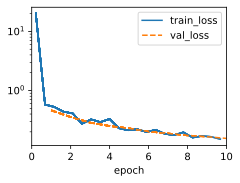

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

Notice that sometimes the number of training errors
for a set of hyperparameters can be very low,
even as the number of errors on $K$-fold cross-validation
grows considerably higher.
This indicates that we are overfitting.
Throughout training you will want to monitor both numbers.
Less overfitting might indicate that our data can support a more powerful model.
Massive overfitting might suggest that we can gain
by incorporating regularization techniques.

##  [**Submitting Predictions on Kaggle**]

Now that we know what a good choice of hyperparameters should be,
we might
calculate the average predictions
on the test set
by all the $K$ models.
Saving the predictions in a csv file
will simplify uploading the results to Kaggle.
The following code will generate a file called `submission.csv`.


In [ ]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

Next, as demonstrated in :numref:`fig_kaggle_submit2`,
we can submit our predictions on Kaggle
and see how they compare with the actual house prices (labels)
on the test set.
The steps are quite simple:

* Log in to the Kaggle website and visit the house price prediction competition page.
* Click the “Submit Predictions” or “Late Submission” button.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

![Submitting data to Kaggle](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/kaggle-submit2.png?raw=1)
:width:`400px`
:label:`fig_kaggle_submit2`

## Summary and Discussion

Real data often contains a mix of different data types and needs to be preprocessed.
Rescaling real-valued data to zero mean and unit variance is a good default. So is replacing missing values with their mean.
Furthermore, transforming categorical features into indicator features allows us to treat them like one-hot vectors.
When we tend to care more about
the relative error than about the absolute error,
we can
measure the discrepancy in the logarithm of the prediction.
To select the model and adjust the hyperparameters,
we can use $K$-fold cross-validation .



## Exercises

1. Submit your predictions for this section to Kaggle. How good are they?
1. Is it always a good idea to replace missing values by a mean? Hint: can you construct a situation where the values are not missing at random?
1. Improve the score by tuning the hyperparameters through $K$-fold cross-validation.
1. Improve the score by improving the model (e.g., layers, weight decay, and dropout).
1. What happens if we do not standardize the continuous numerical features as we have done in this section?


[Discussions](https://discuss.d2l.ai/t/107)


In [ ]:
hparams = {
    "epoch": [5, 10, 20],
    "batch_size": [32, 64, 128],
    "lr": [0.001, 0.01, 0.1]
}

KeyboardInterrupt: 

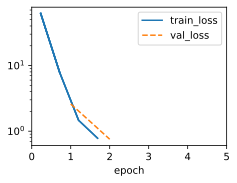

In [ ]:
from itertools import product
keys = hparams.keys()
values = hparams.values()

models = []
average_val_log_mses = []

# Iterate over all combinations
for i, combo in enumerate(product(*values)):
    print(f"{i}/9")
    params = dict(zip(keys, combo))
    data = KaggleHouse(batch_size=params['batch_size'])
    data.preprocess()
    trainer = d2l.Trainer(max_epochs=params['epoch'])
    h_models, average_val_log_mse = k_fold(trainer, data, k=5, lr=params['lr'])
    models.append(h_models)
    average_val_log_mses.append(average_val_log_mse)
    print(f"Average loss: ")

In [ ]:
average_val_log_mses

[0.48681517273187636,
 0.19609333127737044,
 nan,
 0.5652838563919067,
 0.2685654193162918,
 nan,
 0.982044259707133,
 0.34091431498527525,
 inf,
 0.3988894873857498,
 0.12721845775842666,
 nan,
 0.5017150151729585,
 0.18957324981689455,
 nan,
 0.5404897451400756,
 0.25473682483037313,
 nan,
 0.2987891057133675,
 0.08424817580729724,
 nan,
 0.3673030614852905,
 0.11806958705186843,
 nan,
 0.47108403245608016,
 0.17292685558398563,
 nan]

In [ ]:
for i, combo in enumerate(product(*values)):
  params = dict(zip(keys, combo))
  if i == 19:
    print(params)

{'epoch': 20, 'batch_size': 32, 'lr': 0.01}


average validation log mse = 0.08697047227062285
0.08697047227062285


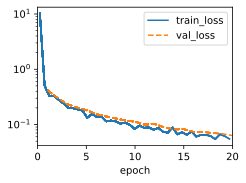

In [ ]:
data = KaggleHouse(batch_size=32)
data.preprocess()
trainer = d2l.Trainer(max_epochs=20)
h_models, average_val_log_mse = k_fold(trainer, data, k=5, lr=0.01)
print(average_val_log_mse)

In [ ]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in h_models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

In [ ]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

In [ ]:
import torch.optim as optim


model = DropoutMLP(1, 331, 256, 0.3, 0.5, 0.01)
weight_decay = 1e-4

optimizer = optim.SGD(model.net.parameters(), lr=model.lr, weight_decay=weight_decay)

In [ ]:
data = KaggleHouse(batch_size=params['batch_size'])
data.preprocess()

In [ ]:
import torch

In [ ]:
torch.tensor(data.train.values, dtype=torch.float32)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Step 1: Load your data (example here, replace with actual load) ---
data = pd.read_csv('/data/kaggle_house_pred_train.csv')  # Adjust path accordingly

# --- Step 2: Separate features and target ---
# Assuming 'SalePrice' is the target in the housing dataset
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

# --- Step 3: Handle missing values ---
# Simple way: fill numeric NaNs with median, categorical with mode
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].fillna(X[col].mode()[0])
    else:
        X[col] = X[col].fillna(X[col].median())

# --- Step 4: Encode categorical features ---
X = pd.get_dummies(X, dummy_na=True)

# --- Step 5: Scale numeric features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 6: Convert target to tensor (also scale target for regression stability) ---
y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
y_mean, y_std = y.mean(), y.std()
y = (y - y_mean) / y_std  # normalize target

# --- Step 7: Convert features to tensor ---
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# --- Step 8: Split into train/test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y, test_size=0.2, random_state=42)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# --- Step 9: Define your model with dropout ---
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden1=256, hidden2=128, dropout1=0.2, dropout2=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1), nn.ReLU(),
            nn.Dropout(dropout1),
            nn.Linear(hidden1, hidden2), nn.ReLU(),
            nn.Dropout(dropout2),
            nn.Linear(hidden2, 1)
        )

    def forward(self, X):
        return self.net(X)

# --- Step 10: Instantiate model and optimizer with weight decay ---
model = DropoutMLP(input_dim=X_train.shape[1])

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # weight_decay = L2 reg

loss_fn = nn.MSELoss()

# --- Step 11: Training loop ---
def train_epoch(model, data_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(data_loader.dataset)

def evaluate(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(data_loader.dataset)

# --- Step 12: Run training ---
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn)
    val_loss = evaluate(model, test_loader, loss_fn)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/20 - Train Loss: 0.5065, Val Loss: 0.2496
Epoch 2/20 - Train Loss: 0.2234, Val Loss: 0.2107
Epoch 3/20 - Train Loss: 0.1472, Val Loss: 0.1768
Epoch 4/20 - Train Loss: 0.1196, Val Loss: 0.1565
Epoch 5/20 - Train Loss: 0.0921, Val Loss: 0.1589
Epoch 6/20 - Train Loss: 0.0757, Val Loss: 0.1512
Epoch 7/20 - Train Loss: 0.0723, Val Loss: 0.1561
Epoch 8/20 - Train Loss: 0.0741, Val Loss: 0.1420
Epoch 9/20 - Train Loss: 0.0671, Val Loss: 0.1442
Epoch 10/20 - Train Loss: 0.0587, Val Loss: 0.1374
Epoch 11/20 - Train Loss: 0.0752, Val Loss: 0.1397
Epoch 12/20 - Train Loss: 0.0629, Val Loss: 0.1366
Epoch 13/20 - Train Loss: 0.0685, Val Loss: 0.1523
Epoch 14/20 - Train Loss: 0.0601, Val Loss: 0.1312
Epoch 15/20 - Train Loss: 0.0563, Val Loss: 0.1410
Epoch 16/20 - Train Loss: 0.0584, Val Loss: 0.1302
Epoch 17/20 - Train Loss: 0.0562, Val Loss: 0.1139
Epoch 18/20 - Train Loss: 0.0561, Val Loss: 0.1328
Epoch 19/20 - Train Loss: 0.0598, Val Loss: 0.1365
Epoch 20/20 - Train Loss: 0.0509, Val Lo

In [ ]:
import itertools

# Your hyperparameter grid:
epochs_list = [20, 30, 40]
lr_list = [0.1, 0.01, 0.001]
batch_sizes = [32, 64, 128]
weight_decays = [1e-3, 1e-4, 1e-5]

results = []

for epochs, lr, batch_size, weight_decay in itertools.product(epochs_list, lr_list, batch_sizes, weight_decays):
    print(f"Training with epochs={epochs}, lr={lr}, batch_size={batch_size} weight_decay={weight_decay}")

    # Re-create DataLoader with current batch size
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Re-initialize the model and optimizer each time!
    model = DropoutMLP(input_dim=X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train for current config
    for epoch in range(epochs):
        train_epoch(model, train_loader, optimizer, loss_fn)

    val_loss = evaluate(model, test_loader, loss_fn)
    print(f"Validation loss: {val_loss:.4f}\n")

    results.append({
        'epochs': epochs,
        'lr': lr,
        'batch_size': batch_size,
        'weight_decay': weight_decay,
        'val_loss': val_loss
    })

# Sort results by validation loss
results = sorted(results, key=lambda x: x['val_loss'])
print("Best config:")
print(results[0])


Training with epochs=20, lr=0.1, batch_size=32 weight_decay=0.001
Validation loss: 1.2170

Training with epochs=20, lr=0.1, batch_size=32 weight_decay=0.0001
Validation loss: 1.2190

Training with epochs=20, lr=0.1, batch_size=32 weight_decay=1e-05
Validation loss: 1.2229

Training with epochs=20, lr=0.1, batch_size=64 weight_decay=0.001
Validation loss: 1.2176

Training with epochs=20, lr=0.1, batch_size=64 weight_decay=0.0001
Validation loss: 1.2171

Training with epochs=20, lr=0.1, batch_size=64 weight_decay=1e-05
Validation loss: 1.2161

Training with epochs=20, lr=0.1, batch_size=128 weight_decay=0.001
Validation loss: 1.2154

Training with epochs=20, lr=0.1, batch_size=128 weight_decay=0.0001
Validation loss: 1.2647

Training with epochs=20, lr=0.1, batch_size=128 weight_decay=1e-05
Validation loss: 0.7902

Training with epochs=20, lr=0.01, batch_size=32 weight_decay=0.001
Validation loss: 1.0195

Training with epochs=20, lr=0.01, batch_size=32 weight_decay=0.0001
Validation loss

In [ ]:
# Step 1: Re-train the best model on full training data (train + validation if you want)
# Here we'll just retrain on training data for simplicity.

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

model = DropoutMLP(input_dim=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

num_epochs = 40
for epoch in range(num_epochs):
    train_epoch(model, train_loader, optimizer, loss_fn)

# Load test data
test_data = pd.read_csv('/data/kaggle_house_pred_test.csv')

# Save the Ids exactly as they appear
test_ids = test_data['Id']

# Preprocess test_data features as before (excluding the Id column)
test_features = test_data.drop(columns=['Id'])

# Fill missing values & one-hot encode like before
for col in test_features.columns:
    if test_features[col].dtype == 'object':
        test_features[col] = test_features[col].fillna(test_features[col].mode()[0])
    else:
        test_features[col] = test_features[col].fillna(test_features[col].median())

test_features = pd.get_dummies(test_features, dummy_na=True)

# Align columns with training data columns (fill missing with 0)
test_features = test_features.reindex(columns=X.columns, fill_value=0)

# Scale features
test_scaled = scaler.transform(test_features)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32)

# Predict
model.eval()
with torch.no_grad():
    preds = model(test_tensor).reshape(-1)

# Un-normalize predictions
preds = preds * y_std + y_mean

# Prepare submission dataframe with the original Ids
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': preds.numpy()
})

submission.to_csv('submissions.csv', index=False)

print("Submission saved with correct Ids.")



Submission saved with correct Ids.
